In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pickle
import random 

rng = np.random.default_rng(926334)

#labels helpers and processing
def pivot_df(df, id_col, ignore_cols=None):
    if not ignore_cols:
        ignore_cols = []
    date_cols = [x for x in df.columns if x not in [id_col] + ignore_cols]
    dfs = []
    for day in date_cols:
        day_df = df[[id_col, day]].rename({day: 'snowpack'}, axis=1)
        day_df['date'] = day
        dfs.append(day_df)
    return pd.concat(dfs)

def daynum_gen(date_time):
    '''converts date time objects to filename'''
    date_time = datetime.fromisoformat(date_time)
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

Load data

In [2]:
data_path = "C:/Users/Matt/Dropbox/SnowComp/FinalData/"

y_train  = pd.read_csv(data_path + "train_y.csv")
y_test  = pd.read_csv(data_path + "test_y.csv")

x_train = np.load(data_path + "train_dataset.npy")
x_test = np.load(data_path + "test_datast.npy")

## Image pixel value distribution

In [18]:
x_train[0,1]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.98039216, 0.98039216, 0.98039216,
        0.27843137, 0.21568627, 0.21568627, 0.78823529, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.92941176, 0.92941176, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.78823529, 0.19215686,
        0.26666667, 0.26666667, 0.16078431, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.92941176, 0.92941176, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.78823529, 0.78823529, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.92941176, 0.92941176, 0.92941176, 0.92941176, 0.92941176,
        0.92941176, 0.78823529, 0.        , 0.       

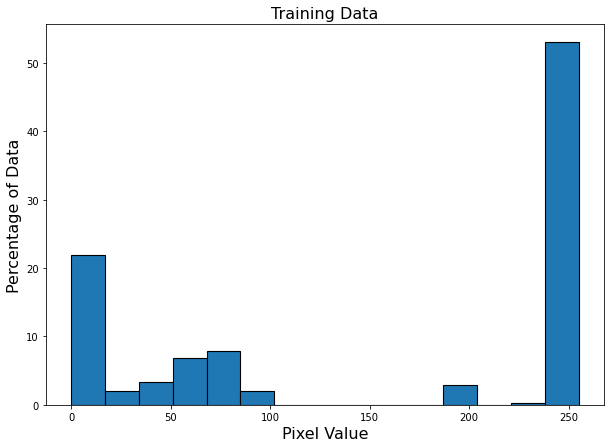

In [47]:
fig, ax = plt.subplots(figsize = (10,7))
ax.hist(x_train.flatten()*255,
        weights = np.ones_like(x_train.flatten()) / x_train.flatten().size*100,
        bins = 15, edgecolor='black', linewidth=1.1)
ax.ticklabel_format(style='plain')
ax.set_ylabel("Percentage of Data", fontsize= 16)
ax.set_xlabel("Pixel Value", fontsize= 16)
ax.set_title("Training Data", fontsize= 16)
plt.show()

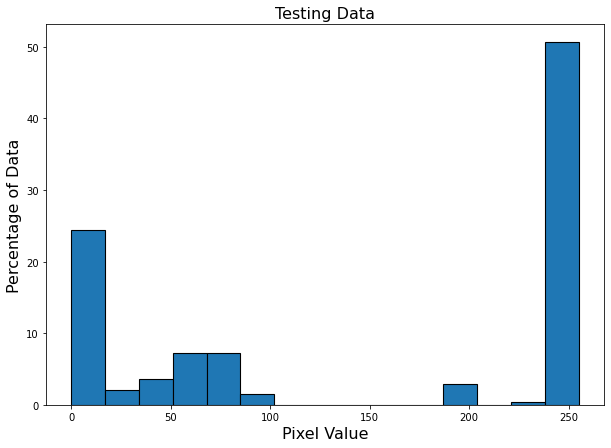

In [48]:
fig, ax = plt.subplots(figsize = (10,7))
ax.hist(x_test.flatten()*255,
        weights = np.ones_like(x_test.flatten()) / x_test.flatten().size*100,
        bins = 15, edgecolor='black', linewidth=1.1)
ax.ticklabel_format(style='plain')
ax.set_ylabel("Percentage of Data", fontsize= 16)
ax.set_xlabel("Pixel Value", fontsize= 16)
ax.set_title("Testing Data", fontsize= 16)
plt.show()

In [57]:
#percentage more than 100 (55.67%)

round(((x_test.flatten()*255 > 100).sum() +(x_train.flatten()*255 > 100).sum())/(
    len(x_train.flatten()) + len(x_test.flatten())), 4)

0.5567

## How many have both Aqua and Terra images on one day

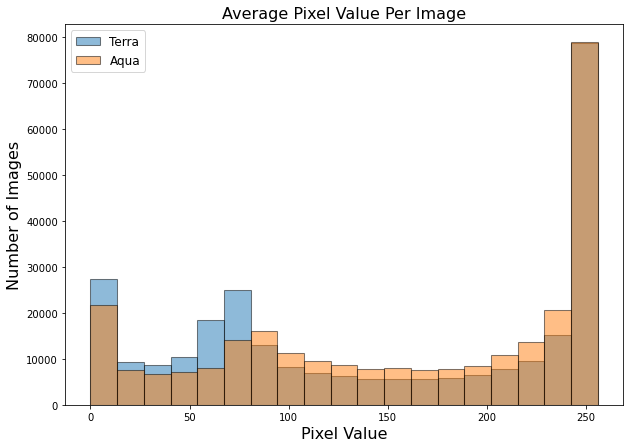

In [83]:
#aqua average pixel value
plt_data = (np.vstack((x_train, x_test))*255).mean(axis = (2,3))

fig, ax = plt.subplots(figsize = (10,7))

bins = np.linspace(0, 256, 20)

ax.hist(plt_data[:,0], bins, alpha=0.5, label='Terra',
        edgecolor='black', linewidth=1.05)
ax.hist(plt_data[:,1], bins, alpha=0.5, label='Aqua',
        edgecolor='black', linewidth=1.05)

ax.ticklabel_format(style='plain')
ax.set_ylabel("Number of Images", fontsize= 16)
ax.set_xlabel("Pixel Value", fontsize= 16)
ax.set_title("Average Pixel Value Per Image", fontsize= 16)

ax.legend(fontsize = 12)
plt.show()

In [84]:
total = plt_data.shape[0]

#how many 0, how many 250+?
print("less than 1:", (plt_data < 1).sum(axis=0)/total*100)
print("greater than 249:", (plt_data > 249).sum(axis=0)/total*100)
print("greater than 100:", (plt_data > 100).sum(axis=0)/total*100)

less than 1: [4.10056432 3.2918328 ]
greater than 249: [22.73677376 21.48409714]
greater than 100: [57.67237071 68.52075452]


## Within-image Missingness histogram

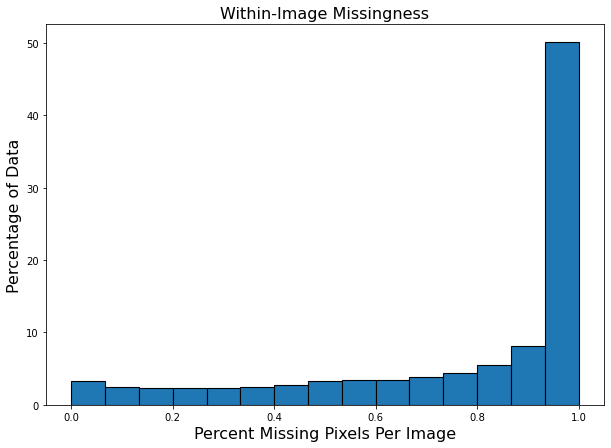

In [91]:
plt_data = ((np.vstack((x_train, x_test))*255 > 100) |
 (np.vstack((x_train, x_test))*255 < 1)).sum(axis = (1,2,3))/(21*21*2)


fig, ax = plt.subplots(figsize = (10,7))
ax.hist(plt_data.flatten(),
        weights = np.ones_like(plt_data) / plt_data.size*100,
        bins = 15, edgecolor='black', linewidth=1.1)
ax.ticklabel_format(style='plain')
ax.set_ylabel("Percentage of Data", fontsize= 16)
ax.set_xlabel("Percent Missing Pixels Per Image", fontsize= 16)
ax.set_title("Within-Image Missingness", fontsize= 16)
plt.show()

In [94]:
print("100% missing:", (plt_data > .999).sum()/len(plt_data)*100)

100% missing: 21.905425468659374


## Panel of images + predictions, compared to actual values

In [45]:
ROOT = 'C:/Users/Matt/Documents/Python Scripts/SnowComp/realtime/'
MODIS_CNN_PATH = ROOT + 'model_32_18_8_3_0.13_50_1399_0.0001' #'modis_model'

import sys
sys.path.append(ROOT)

import torch
from modis_cnn import Net as ModisNet

net_kwargs = {'cdim1': 32,
              'cdim2': 18,
              'cdim3': 8,
              'kernel_sz': 3,
              'dropout': 0.13,
              'ldim': 50}


modis_net = ModisNet(**net_kwargs)
modis_net.load_state_dict(torch.load(MODIS_CNN_PATH))

c1 dim: 19
mp0 dim: 17
c2 dim: 15
mp1 dim: 13
c3 dim: 11
mp2 dim: 9
flattened_dim 648


<All keys matched successfully>

In [72]:
idx = np.random.randint(low=0, high=x_test.shape[0], size=(nsamples,)) 
y_test.iloc[idx,0].values

array(['SNOTEL:520_ID_SNTL', 'SNOTEL:487_MT_SNTL', 'SNOTEL:324_ID_SNTL',
       '384f2df2-0974-4092-a2da-42d7750038b1',
       'fdeb8912-f9d1-445d-aadb-e943534f67fe', 'SNOTEL:717_CO_SNTL',
       'SNOTEL:474_UT_SNTL', 'd04ccae0-5fc0-4f96-bf1b-44a676b3b49e'],
      dtype=object)

In [70]:
y_train[y_train.cell_id == y_test.iloc[idx,0].values[0]]

,cell_id,snowpack,date
523,SNOTEL:457_CO_SNTL,0.0,2018135
1260,SNOTEL:457_CO_SNTL,17.5,2013106
2819,SNOTEL:457_CO_SNTL,14.1,2019029
4587,SNOTEL:457_CO_SNTL,9.9,2019358
5886,SNOTEL:457_CO_SNTL,9.2,2016362
...,...,...,...
219342,SNOTEL:457_CO_SNTL,22.9,2014070
219987,SNOTEL:457_CO_SNTL,6.0,2016348
219988,SNOTEL:457_CO_SNTL,6.2,2018009
220913,SNOTEL:457_CO_SNTL,17.0,2018086


### Training

Match the training and testing datasets by location in different times

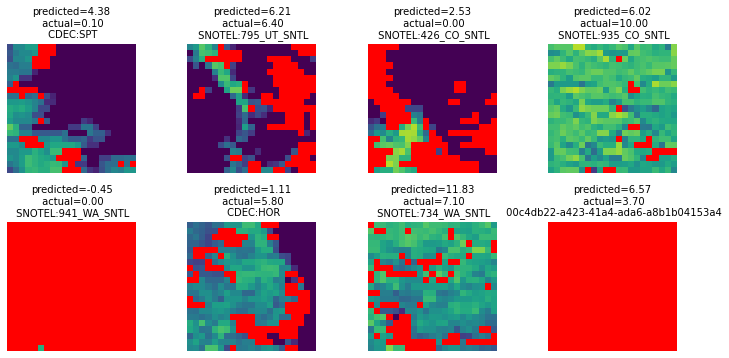

In [78]:
nsamples = 8

idx = np.random.randint(low=0, high=x_test.shape[0], size=(nsamples,))
# idx = np.array([176120,  16587, 120640, 172680, 181050, 109652, 118646, 217709]) # good set of train not completely missing days
# idx = np.array([  813,  2586,  8527, 47244, 45731, 21826, 10435, 44521]) #decent test set

samples = x_test[idx]
preds = modis_net(torch.Tensor(x_test[idx])).detach().numpy()
actual = y_test.iloc[idx].snowpack.values
sites = y_test.iloc[idx,0].values

nrows = 2
ncols = 4
h = 3 * nrows
w = 3 * ncols

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(w, h))

for i in range(nsamples):
    ii = i // ncols
    jj = i % ncols
    

    which_sat = 0 if (samples[i, 0, :, :]*255 >100).sum() <= (samples[i, 1, :, :]*255 >100).sum() else 1
    
    samples[i, which_sat, :, :][samples[i, which_sat, :, :] > .395] = np.nan #above 100/255
    
    current_cmap = cm.get_cmap().copy()
    current_cmap.set_bad(color='red')
    
    ax[ii, jj].imshow(
        samples[i, which_sat, :, :], vmin=0, vmax=.395,
        cmap = current_cmap
    )
    
    #title would be prediction score vs actual
    ax[ii, jj].set_title(
        f"predicted={float(preds[i]):.2f}\n actual={float(actual[i]):.2f}\n {sites[i]}", fontsize=10
    )
    
    ax[ii, jj].axis("off")
    
fig.subplots_adjust(hspace=0.2, wspace=0.4)


Way more missingness for remote sites?

In [102]:
def is_groundsite(name):
    if name[0:4] in {"CDEC", "SNOT"}:
        return True
    return False

ground_idx_te = y_test.cell_id.map(is_groundsite)
print("testing obs ground:",ground_idx_te.sum(), "of", len(ground_idx_te), f"({ground_idx_te.sum()/len(ground_idx_te):.2%})") 

ground_idx_tr = y_train.cell_id.map(is_groundsite)
print("training obs ground:",ground_idx_tr.sum(), "of", len(ground_idx_tr), f"({ground_idx_tr.sum()/len(ground_idx_tr):.2%})") 

testing obs: 38628 of 52400 (73.72%)
training obs: 144015 of 221733 (64.95%)


In [112]:
missing_pix = (x_train[ground_idx_tr.values] *255 > 100.1).sum()
total_pix = len(x_train[ground_idx_tr.values].flatten())
print("training pixels missing (Ground): ", missing_pix, "of", total_pix, f"({missing_pix/total_pix:.2%})") 

missing_pix = (x_test[ground_idx_te.values] *255 > 100.1).sum()
total_pix = len(x_test[ground_idx_te.values].flatten())
print("testing pixels missing (Ground): ", missing_pix, "of", total_pix, f"({missing_pix/total_pix:.2%})") 

missing_pix = (x_train[~ground_idx_tr.values] *255 > 100.1).sum()
total_pix = len(x_train[~ground_idx_tr.values].flatten())
print("training pixels missing (ASO): ", missing_pix, "of", total_pix, f"({missing_pix/total_pix:.2%})") 

missing_pix = (x_test[~ground_idx_te.values] *255 > 100.1).sum()
total_pix = len(x_test[~ground_idx_te.values].flatten())
print("testing pixels missing (ASO): ", missing_pix, "of", total_pix, f"({missing_pix/total_pix:.2%})") 

training pixels missing (Ground):  79925244 of 127021230 (62.92%)
testing pixels missing (Ground):  19589920 of 34069896 (57.50%)
training pixels missing (ASO):  29808269 of 68547276 (43.49%)
testing pixels missing (ASO):  5285374 of 12146904 (43.51%)


Where do all missing images get mapped to?
The mean value of the training set?